In [1]:
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
test  = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")

train.drop(columns=["id"], inplace=True)
test.drop(columns=["id"], inplace=True)

In [3]:
sample_submission.head()

,id,BeatsPerMinute
0,524164,119.035
1,524165,119.035
2,524166,119.035
3,524167,119.035
4,524168,119.035


In [4]:
train.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [5]:
test.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.5498,0.424867
1,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.6643,0.846000
2,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.0127,0.134067
3,0.885793,-5.598049,0.118488,0.000005,0.376906,0.134435,0.487740,271790.3989,0.316467
4,0.637391,-7.068160,0.126099,0.539073,0.068950,0.024300,0.591248,277728.5383,0.481067


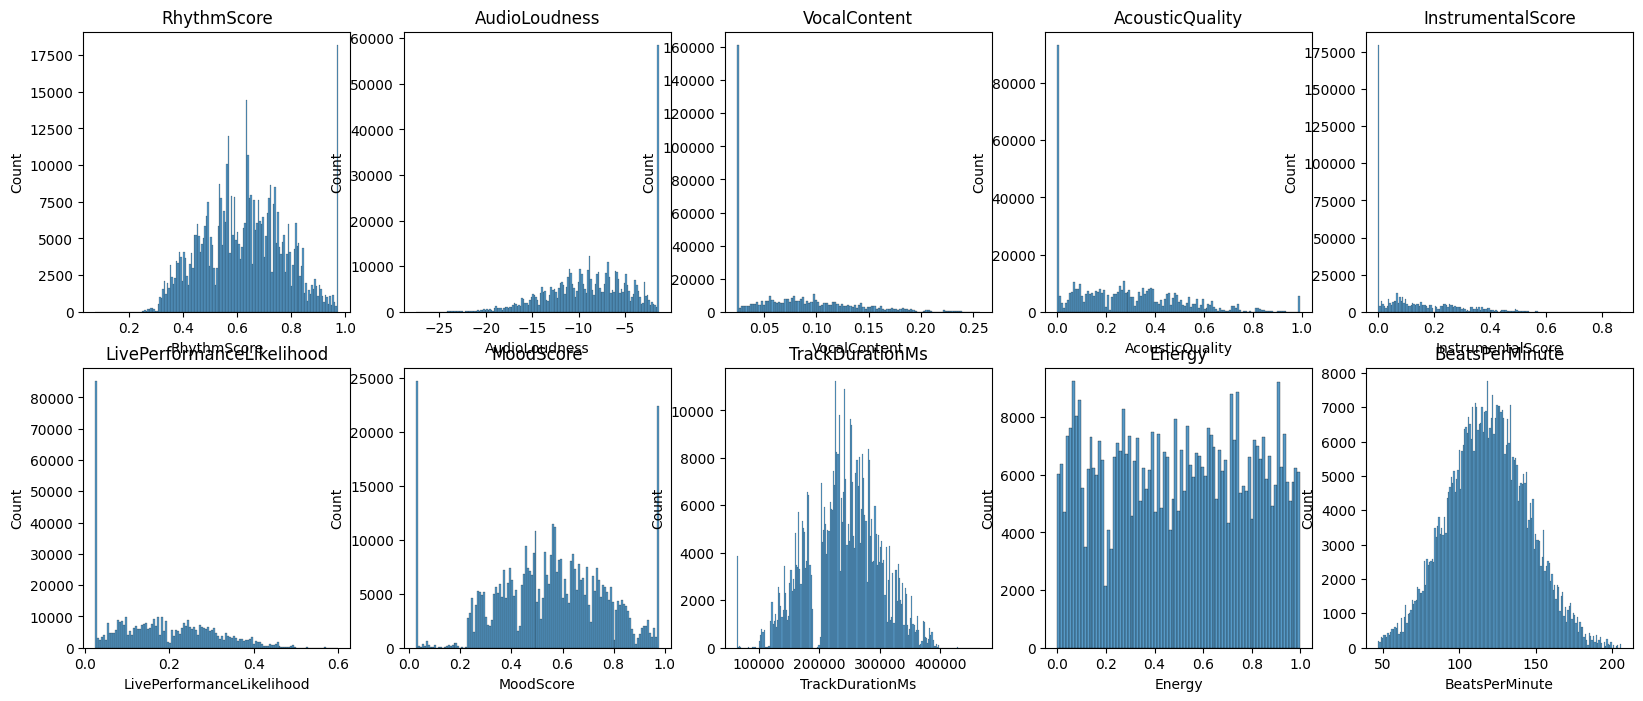

In [6]:
plt.figure(figsize=(20,8))
for i,col in enumerate(train.columns):
    plt.subplot(2, 5, i+1)
    sea.histplot(train[col])
    plt.title(col)

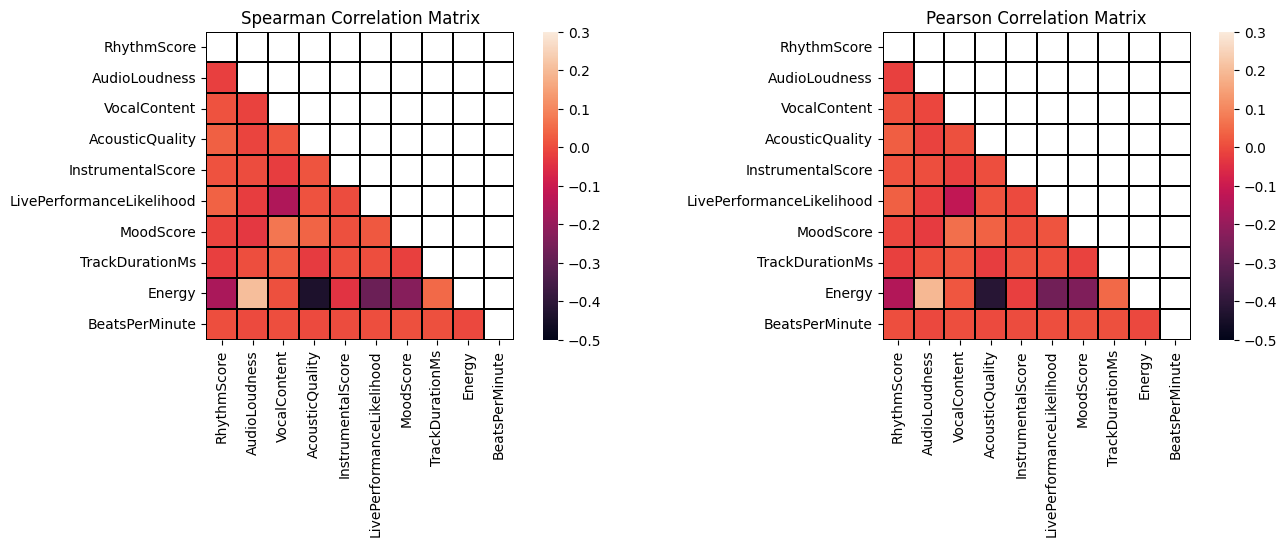

In [7]:
plt.figure(figsize=(16,4))

M_corr = train.corr(method="spearman")
U_mask = np.triu(M_corr)
plt.subplot(121)
sea.heatmap(M_corr, mask=U_mask, 
            vmin=-.5, vmax=.3, 
            linecolor="black", linewidths=.25,
            square=True
           )
plt.title("Spearman Correlation Matrix")



M_corr = train.corr(method="pearson")
U_mask = np.triu(M_corr)
plt.subplot(122)
sea.heatmap(M_corr, mask=U_mask, 
            vmin=-.5, vmax=.3, 
            linecolor="black", linewidths=.25,
            square=True
           )
plt.title("Pearson Correlation Matrix")

plt.show()

# Linear Regression Model for Inference

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

In [9]:
## RMSE Metric
RMSE = lambda y_true, y_pred: np.sqrt(np.mean((y_true - y_pred)**2))

## Splitted dataset
X = train.copy()
y = X.pop("BeatsPerMinute")

standard_scaler = StandardScaler()

In [10]:
def cross_validate(model, X, y, n_splits=10, scaler=None):
    ## Converts to numpy arrays
    X_npy = np.asarray(X)
    y_npy = np.asarray(y)
        
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=3126)
    y_oof = np.zeros_like(y_npy, dtype=float)
    rmse  = []
    history = {}
        
    for train_idx,val_idx in kfold.split(X_npy):
        X_train, y_train = X_npy[train_idx], y_npy[train_idx]
        X_val,   y_val   = X_npy[val_idx],   y_npy[val_idx]

        if scaler is not None:
            X_train = scaler.fit_transform(X_train)
            X_val   = scaler.transform(X_val)
        
        ## Fits cloned model
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        ## Gets OOF prediction and stores it
        y_pred = cloned_model.predict(X_val)
        y_oof[val_idx] = y_pred
        ## Stores metric
        rmse.append(RMSE(y_val, y_pred))

    history["y_oof"] = y_oof
    history["rmse"]  = np.array(rmse)
    return history

In [11]:
lr = LinearRegression(n_jobs=-1)
history_lr = cross_validate(lr, X, y, n_splits=10, scaler=standard_scaler)

ridge = Ridge(alpha=1, random_state=3126)
history_ridge = cross_validate(ridge, X, y, n_splits=10, scaler=standard_scaler)

lasso = Lasso(alpha=1, random_state=3126)
history_lasso = cross_validate(lasso, X, y, n_splits=10, scaler=standard_scaler)

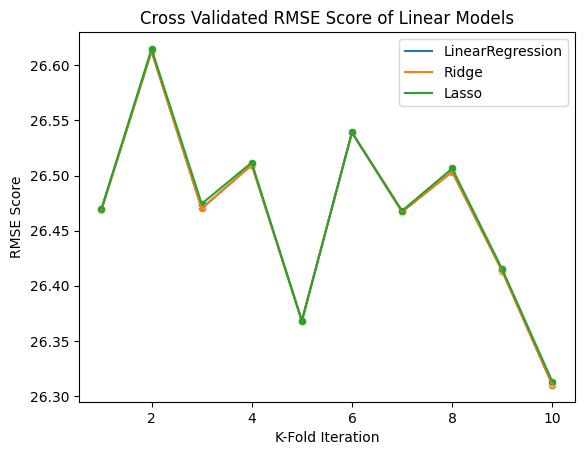

In [12]:
sea.scatterplot(x=np.arange(1,11), y=history_lr["rmse"])
sea.lineplot(x=np.arange(1,11), y=history_lr["rmse"], label="LinearRegression")

sea.scatterplot(x=np.arange(1,11), y=history_ridge["rmse"])
sea.lineplot(x=np.arange(1,11), y=history_ridge["rmse"], label="Ridge")

sea.scatterplot(x=np.arange(1,11), y=history_lasso["rmse"])
sea.lineplot(x=np.arange(1,11), y=history_lasso["rmse"], label="Lasso")

plt.xlabel("K-Fold Iteration")
plt.ylabel("RMSE Score")
plt.title("Cross Validated RMSE Score of Linear Models")
plt.show()

In [13]:
print(f"Linear Regression RMSE: {history_lr['rmse'].mean():.3f} ± {history_lr['rmse'].std():.3f}")
print(f"Ridge RMSE: {history_ridge['rmse'].mean():.3f} ± {history_ridge['rmse'].std():.3f}")
print(f"Lasso RMSE: {history_lasso['rmse'].mean():.3f} ± {history_lasso['rmse'].std():.3f}")

Linear Regression RMSE: 26.466 ± 0.082
Ridge RMSE: 26.466 ± 0.082
Lasso RMSE: 26.468 ± 0.082


In [14]:
ridge = Ridge(alpha=1.0, random_state=3126)
ridge.fit(X, y)

Ridge(random_state=3126)

In [15]:
features = X.columns
coefs = ridge.coef_

ridge_coefs = pd.DataFrame({"feature":features, "ridge_coef":coefs})
ridge_coefs.sort_values(by="ridge_coef", ascending=False)

,feature,ridge_coef
2,VocalContent,2.528574
0,RhythmScore,0.874665
6,MoodScore,0.752628
5,LivePerformanceLikelihood,0.719087
4,InstrumentalScore,0.365533
7,TrackDurationMs,0.000003
1,AudioLoudness,-0.015181
8,Energy,-0.171988
3,AcousticQuality,-0.231923


In [16]:
oof_data = pd.DataFrame(
    {"lr_oof":history_lr["y_oof"], 
     "ridge_oof":history_ridge["y_oof"], 
     "lasso_oof":history_lasso["y_oof"]}
)

oof_data.corr(method="pearson")

,lr_oof,ridge_oof,lasso_oof
lr_oof,1.000000,1.000000,0.031429
ridge_oof,1.000000,1.000000,0.031429
lasso_oof,0.031429,0.031429,1.000000


In [17]:
sample_submission["BeatsPerMinute"] = ridge.predict(test)

In [18]:
sample_submission.to_csv('baseline_ridge.csv', index=False)